<a href="https://colab.research.google.com/github/PHATTARAWAT2312/ConcealedGun/blob/main/1_FasterRCNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detection Conex

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#root_path = 'gdrive/My Drive/ConcealedGunPROJECT2020/'  #change dir to your project folder

Mounted at /content/gdrive


In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
 # XXX: only one GPU on Colab and isn’t             
gpu = GPUs[0]
def printm():
     process = psutil.Process(os.getpid())
     print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
     print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
     printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=1da4137383690de6b7c876324002c13e1df4beb983c770677368d4d8f2ff117f
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [3]:
# import all the tools we need
import urllib
import pandas as pd
import numpy as np
import cv2
import itertools
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests
import glob

In [6]:
# path of images directory
dir_path = '/content/gdrive/MyDrive/CONEX/CONEX_ConcealedGun/image_train280'

# path of xml files directory
csv_path = '/content/gdrive/MyDrive/CONEX/CONEX_ConcealedGun/JAMES/annotation3/'

# List of Image file name 
file_list = os.listdir(dir_path)

# How many image files?
print('There are total {} images.'.format(len(file_list)))

There are total 34180 images.


In [7]:
def read_annot(file_name, csv_path):
  bbox = []
  labels = []

  annot_path = os.listdir(csv_path)
  df = pd.read_csv(csv_path+'/'+annot_path[0])
  df.head()
  for i, data in enumerate(df['FileName']):
    # print(i)
    if df['FileName'][i] == file_name:
        ymin = int(df['Ymin'][i])
        xmin = int(df['Xmin'][i]) 
        ymax = int(df['Ymax'][i])
        xmax = int(df['Xmax'][i])
        label = df['class_id'][i]
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'Gun':
            label_idx = 2
        else:
            label_idx = 1
        labels.append(label_idx)
  return bbox, labels

In [8]:
# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=5):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)
    
    """
    # imgHeight, imgWidth, _ = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # for i in enumerate(score):
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 1:
            label1 = 'No Gun'
            color = (0,225,0) # green
        elif label == 2:
            label1 = 'Gun'
            color = (0,0,225) # red
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
        labelSize=cv2.getTextSize(label1,cv2.FONT_HERSHEY_COMPLEX,1,3)
        # print('labelSize>>',labelSize)
        _x1 = box[0]
        _y1 = box[1]
        _x2 = _x1+labelSize[0][0]
        _y2 = _y1-int(labelSize[0][1])
        cv2.rectangle(img,(_x1,_y1),(_x2,_y2),color,cv2.FILLED)
        cv2.putText(img,label1,(box[0],box[1]),cv2.FONT_HERSHEY_COMPLEX,1,(0,0,0),2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

X5g-4FtRCfc_dup4 163.jpg


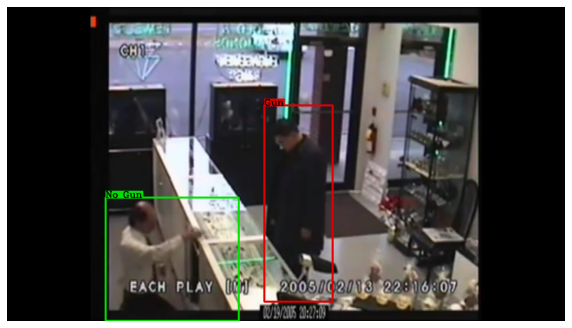

In [9]:
# file_list.sort()
# Get the image randomly
image_name = file_list[random.randint(0,len(file_list))] # random select an image
print(image_name)
# Get the bbox and label
bbox, labels  = read_annot(image_name, csv_path)

#draw bounding boxes on the image
img = draw_boxes(plt.imread(os.path.join(dir_path,image_name)), bbox,labels)
    
# display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img)

In [10]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, csv_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.csv_dir = csv_dir
       
    def __getitem__(self, idx):
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        bbox, labels = read_annot(img_name,self.csv_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

In [11]:
mask_dataset = image_dataset(file_list, dir_path, csv_path)

def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader = DataLoader(mask_dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

In [12]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model = model.to(device)
    return model

In [14]:
# Setting the optimizer, lr_scheduler, epochs
model = get_model_instance_segmentation(3)
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs=1

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [15]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Prediction

In [16]:
# Setting up GPU device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

##*Library Pytorch*
## เรียก Model


In [17]:
# helper function for single image prediction
def single_img_predict(img, nm_thrs = 0.1, score_thrs=0.6):
    # device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_model_instance_segmentation(3)
    model.load_state_dict(torch.load('/content/gdrive/MyDrive/CONEX/CONEX_ConcealedGun/model_train280_1.pth'))
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    score = predictions[0]['scores'].cpu().numpy()[keep_boxes]
    # score = score.astype(int)
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels, score

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


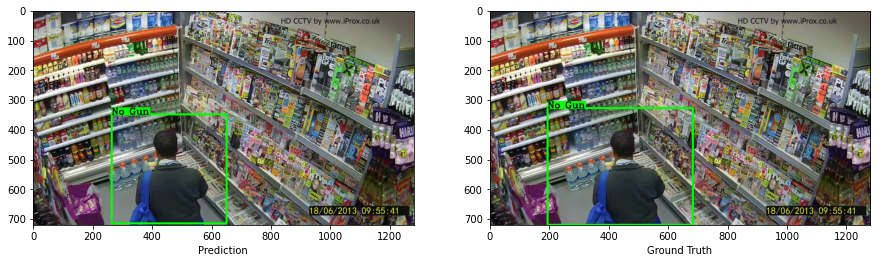

In [18]:
#idx = random.randint(1,len(file_list))
idx = 210
test_img = Image.open(os.path.join(dir_path,file_list[idx])).convert('RGB')

# Prediction
test_img, test_boxes, test_labels, scor = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)

# Draw the bounding box of ground truth
bbox, labels  = read_annot(file_list[idx], csv_path)
#draw bounding boxes on the image
gt_output = draw_boxes(test_img, bbox,labels)

# Display the result
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
ax2.imshow(gt_output)
ax2.set_xlabel('Ground Truth')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[7.70632629e+02 1.37874023e+02 1.02376483e+03 6.92821106e+02]
 [1.27816821e+03 1.26159415e-01 1.47239551e+03 4.29372070e+02]
 [1.11212231e+03 7.46821060e+01 1.31845044e+03 4.95150299e+02]
 [1.29864832e+03 3.13943024e+02 1.68633447e+03 8.72993958e+02]]


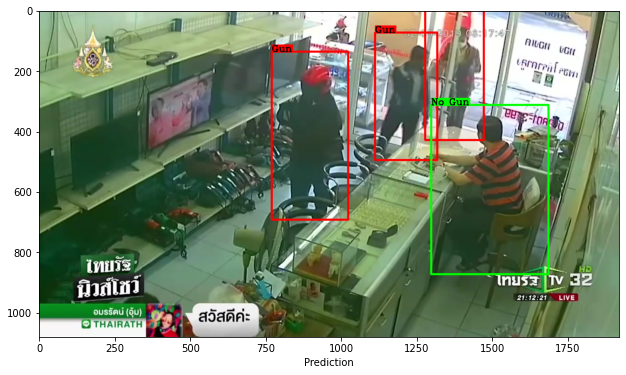

In [19]:
test_img = Image.open(os.path.join('/content/gdrive/MyDrive/CONEX/CONEX_ConcealedGun/GUN/Frames/6agl_Gpig9I/6agl_Gpig9I 110.jpg')).convert('RGB')

# Prediction
test_img, test_boxes, test_labels, score_filter = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)

# Display the result
fig, (ax1) = plt.subplots(1,figsize=(15,6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
print(test_boxes)
test_boxes75 = test_boxes
plt.show()

#FasterRCNN Model


# INPUT VIDEOS

In [24]:
def inputVideo(folder_frame, Num_frame):
  dire = '/content/gdrive/MyDrive/CONEX/CONEX_ConcealedGun/Test_Tracking/'+ folder_frame 
  test = pd.read_csv ('/content/gdrive/MyDrive/CONEX/CONEX_ConcealedGun/DATASET.csv')
  group_per = test.groupby(['Clip_Name','person_id','people']).size().reset_index(name='counts_frame')
  asd = group_per[group_per['Clip_Name'] ==idclip]
  Num_frame= asd['counts_frame'].agg(['max'])
  Num_frame0 = int(Num_frame)
  print(Num_frame0)
  print(asd)
  # หาว่าแต่ละเฟรมเป็นคนเดียวกันมั้ย
  os.chdir(dire)
  imglist = glob.glob("*")
  pred_result = []
  for h in imglist[0:Num_frame0]: #จำนวนเฟรม
      test_img = Image.open(os.path.join(h)).convert('RGB')
      test_img, test_boxes, test_labels, score_filter = single_img_predict(test_img)
      pred_result.append({'test_img':test_img,'test_boxes':test_boxes,'test_labels':test_labels,'score_filter':score_filter})
  df = pd.DataFrame(pred_result)
  result = [] # สร้าง list เก็บ
  frame_num = len(df) #ดูจำนวนเฟรม
  for i in range(frame_num): # ใน 1 เฟรม
      person0 = len(df.test_labels[i]) 
      frame_current = df.test_boxes[i] 
      prob = df.score_filter[i] # ค่า prob 
      img = df.test_img[i] # ขนาดของรูป 
      labels = df.test_labels[i] # class
      try:
          person1 = len(df.test_labels[i+1])
          frame_next = df.test_boxes[i+1]
          for j in range(person0): ## คนแรกในเฟรมที่ 1
              box0 = frame_current[j] # box ของเฟรมแรก
              proba = prob[j] # prob 
              cla = labels[j] # class 
              perlist = [] # เก็บค่า
              for k in range(person1): #คนที่สอง
                  box1= frame_next[k] # Box ของเฟรมถัดไป
                  re = abs(box0 - box1).sum() # หา Distance
                  perlist.append(re)
              perid = perlist.index(min(perlist)) 
              # แทรก list เพื่อเก็บว่า per0 ในเฟรมแรก จะเป็น per คนที่เท่าไหร่ในเฟรมถัดไป
              result.append({'idx_frame':i,'idx_per':j,'idx_per_next':perid,'test_img':img,'test_box':box0,'prob':proba,'pred':cla})
      except:
          person1 = len(df.test_labels[i-1])#ย้อนกลับไปที่ เฟรมก่อนหน้า
          frame_next = df.test_boxes[i-1]
          for j in range(person0):
              box0 = frame_current[j]
              proba = prob[j]
              cla = labels[j]
              perlist = []
              for k in range(person1):
                  box1= frame_next[k]
                  re = abs(box0 - box1).sum()
                  perlist.append(re)
              perid = perlist.index(min(perlist))
              result.append({'idx_frame':i,'idx_per':j,'idx_per_next':perid,'test_img':img,'test_box':box0,'prob':proba,'pred':cla})
  resultdf = pd.DataFrame(result)
  return resultdf
idclip = str(input("ID Clip : "))
test = pd.read_csv ('/content/gdrive/MyDrive/CONEX/CONEX_ConcealedGun/DATASET.csv')
group_per = test.groupby(['Clip_Name','person_id','people']).size().reset_index(name='counts_frame')
asd = group_per[group_per['Clip_Name'] ==idclip]
Num_frame= asd['counts_frame'].agg(['max'])
Num_frame0 = int(Num_frame)
# idclip = str(input("ID Clip : "))
# Ex. C8ud3_vQcw4 , QP57keNgs4o_dup1
resultdf = inputVideo(idclip,Num_frame0)
resultdf

ID Clip : QP57keNgs4o_dup1
60
            Clip_Name  person_id  people  counts_frame
296  QP57keNgs4o_dup1     106687     2.0            60
297  QP57keNgs4o_dup1     106688     2.0            60


,idx_frame,idx_per,idx_per_next,test_img,test_box,prob,pred
0,0,0,0,"[[[0.7607843, 0.78431374, 0.7764706], [0.75686...","[851.3659, 281.56195, 1127.345, 720.0]",0.993495,2
1,0,1,1,"[[[0.7607843, 0.78431374, 0.7764706], [0.75686...","[331.3806, 173.36089, 659.8677, 638.4455]",0.853431,2
2,1,0,0,"[[[0.77254903, 0.79607844, 0.7882353], [0.7647...","[840.2762, 278.33243, 1134.3063, 720.0]",0.995745,2
3,1,1,1,"[[[0.77254903, 0.79607844, 0.7882353], [0.7647...","[341.84348, 172.32713, 661.10675, 640.59796]",0.830117,2
4,2,0,0,"[[[0.7647059, 0.7882353, 0.78039217], [0.75686...","[641.86334, 313.0655, 1094.4243, 720.0]",0.979610,2
...,...,...,...,...,...,...,...
115,57,1,1,"[[[0.7921569, 0.8117647, 0.7882353], [0.788235...","[403.23807, 171.68205, 705.6478, 642.2201]",0.966351,2
116,58,0,0,"[[[0.7921569, 0.8117647, 0.7882353], [0.788235...","[807.8431, 289.4305, 1101.1409, 720.0]",0.993354,2
117,58,1,1,"[[[0.7921569, 0.8117647, 0.7882353], [0.788235...","[399.4706, 143.91852, 733.3408, 637.5762]",0.921413,2
118,59,0,0,"[[[0.7921569, 0.8117647, 0.79607844], [0.78823...","[791.299, 275.43063, 1084.9995, 720.0]",0.994274,2


In [ ]:
# os.chdir('/content/gdrive/MyDrive/CONEX/CONEX_ConcealedGun/Test_Predice_New')
# resultdf.to_csv(r'QP57keNgs4o_dup1.csv', index = False) # 

# Completed ผลลัพธ์ที่ได้ คือ 
  1. คนที่ 0 จะเป็นคนที่เท่าไหร่ในเฟรมถัดไป
  2. พิกัดกรอบครอบร่างกายรายบุคคลในทุกเฟรม
  3. Scor (prob) รายบุคคลในทุกเฟรม
  4. Class (pred) รายบุคคลในทุกเฟรม 
